# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [67]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer, StandardScaler
import pickle 

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [68]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [69]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [70]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [71]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [72]:
azdias.isna().sum().sum()

4896838

In [73]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [74]:
# Identify missing or unknown data values and convert them to NaNs.

# Prepare str for conversion
miss_tag = feat_info['missing_or_unknown'].str.replace('[','')
miss_tag = miss_tag.str.replace(']','')
feat_info['clean_tag'] = miss_tag
feat_info.head()


,attribute,information_level,type,missing_or_unknown,clean_tag
0,AGER_TYP,person,categorical,"[-1,0]","-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","-1,0,9"
2,ANREDE_KZ,person,categorical,"[-1,0]","-1,0"
3,CJT_GESAMTTYP,person,categorical,[0],0
4,FINANZ_MINIMALIST,person,ordinal,[-1],-1


In [75]:
# Fill missing/erroneous values with NaN
for column in range(azdias.shape[1]):
    tag_tup = feat_info.iloc[column]['clean_tag']
    tag_arr = tag_tup.split(sep=",")
    tag = [eval(i) if (i != 'X' and i != 'XX' and i != '') else i for i in tag_arr] # Convert sttr to int
    if tag != ['']:
        azdias = azdias.replace({feat_info.iloc[column]['attribute']:tag}, np.nan) # Nested dict for finding tag values in attribute

In [76]:
azdias.isna().sum().sum()

8373929

In [77]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,NaN,4.0,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [78]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Percentage of missing values for features

azdias_nan = (azdias.isna().sum()/len(azdias))*100
azdias_nan.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

Text(0,0.5,'Num of Features')

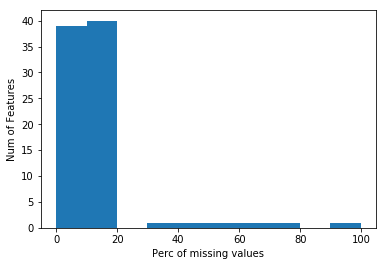

In [79]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias_nan)
plt.xlabel('Perc of missing values')
plt.ylabel('Num of Features')

In [80]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = azdias_nan[azdias_nan >= 30] # Based on a 30% threshold
azdias.drop(outliers.index, axis=1, inplace=True)


In [81]:
azdias.shape

(891221, 79)

In [82]:
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

By inspecting the missing values of the dataset, we can deduct that most of the features have between 10-20% missing values and 9/10 of them are in the range of 0-20%. The total amount of data missing is proportionwise about 11.1% of the total data, meaning its effect isn't much significant. Removing the AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP and KBA05_BAUMAX the dataset is cleaner, as its outliers have been removed. We can also observe that groups of data with similar names have about the same ratio of missing values (if not identical).

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [83]:
# How much data is missing in each row of the dataset?
azd_rownan = (azdias.isna().sum(axis=1)/len(azdias.columns))*100
azd_rownan.sort_values(ascending=False)

643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
691141    59.493671
691142    59.493671
691171    59.493671
691183    59.493671
139332    59.493671
691197    59.493671
139323    59.493671
691212    59.493671
691122    59.493671
139267    59.493671
139255    59.493671
139250    59.493671
139248    59.493671
139245    59.493671
139243    59.493671
691317    59.493671
691129    59.493671
691118    59.493671
139236    59.493671
139478    59.493671
690871    59.493671
690876    59.493671
690878    59.493671
690887    59.493671
139521    59.493671
            ...    
540246     0.000000
540244     0.000000
540243     0.000000
540242     0.000000
540241     0.000000
540240     0.000000
540239     0.000000
540269     0.000000
540271     0.000000
540300     0.000000
540289     0.000000
540299     0.000000
540298     0.000000
540296     0.000000
540295     0.000000
540293     0.000000
540292     0.000000
540291     0.000000
540290     0.000000


Text(0,0.5,'Num of People')

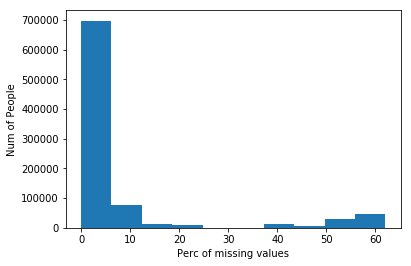

In [84]:
plt.hist(azd_rownan)
plt.xlabel('Perc of missing values')
plt.ylabel('Num of People')

In [85]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_out = azd_rownan[azd_rownan >= 15] # 15% threshold
azdias_in = azd_rownan.drop(azdias_out.index)

print(azdias_out.shape, azdias_in.shape)

(109941,) (781280,)


In [86]:
azdias_above15 = azdias.iloc[azdias_out.index, :]
azdias_below15 = azdias.iloc[azdias_in.index, :]

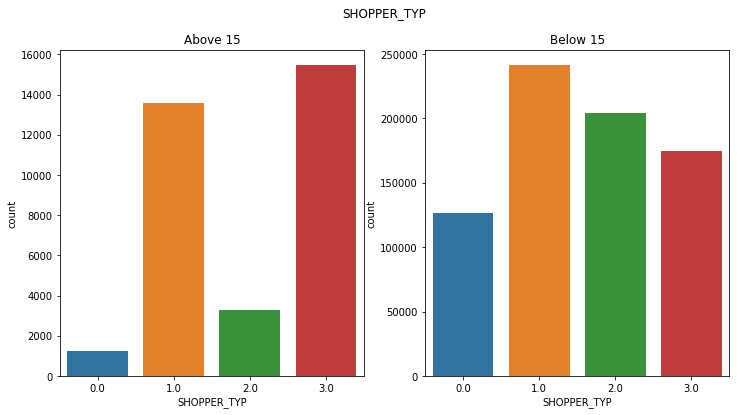

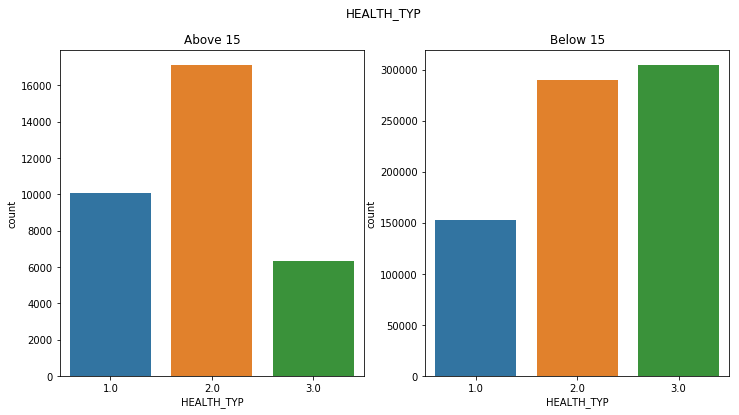

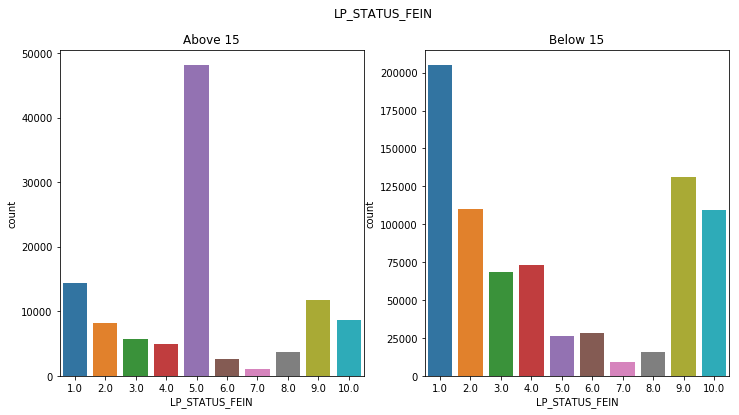

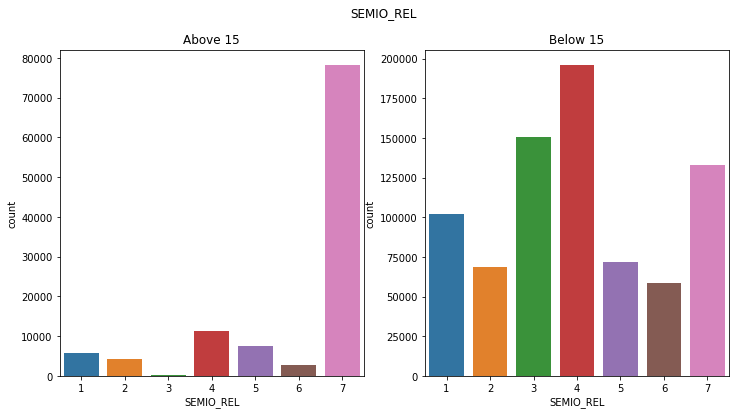

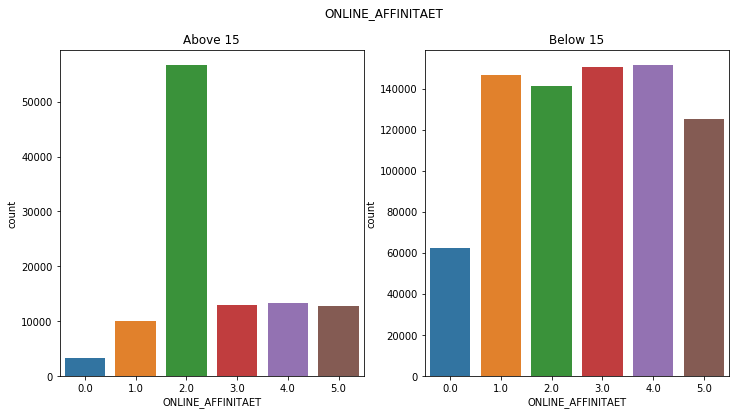

In [87]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_hist(column):
    fig = plt.figure(10, figsize=(12,6))
    
    ax1 = fig.add_subplot(121)
    ax1 = plt.title('Above 15')
    sns.countplot(azdias_above15[column.name])
    
    ax1 = fig.add_subplot(122)
    ax1 = plt.title('Below 15')
    sns.countplot(azdias_below15[column.name])
    
    fig.suptitle(column.name)
    plt.show()
    
compare_hist(azdias['SHOPPER_TYP'])
compare_hist(azdias['HEALTH_TYP'])
compare_hist(azdias['LP_STATUS_FEIN'])
compare_hist(azdias['SEMIO_REL'])
compare_hist(azdias['ONLINE_AFFINITAET'])

#### Discussion 1.1.3: Assess Missing Data in Each Row

It seems that for the data with missing values, there's one index that is peaking and the rest are relatively low. So, comparatively with the other subset, there's not a distinct distribution, as such, observed.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [88]:
# How many features are there of each data type?
col_list = azdias_below15.columns.tolist()
feat_info_2 = feat_info[feat_info['attribute'].isin(col_list)] # Based on new dataset
# feat_info
feat_info_2['type'].value_counts() 

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [89]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categoricals = feat_info_2[feat_info_2['type'] == 'categorical']
categoricals

,attribute,information_level,type,missing_or_unknown,clean_tag
2,ANREDE_KZ,person,categorical,"[-1,0]","-1,0"
3,CJT_GESAMTTYP,person,categorical,[0],0
10,FINANZTYP,person,categorical,[-1],-1
12,GFK_URLAUBERTYP,person,categorical,[],
13,GREEN_AVANTGARDE,person,categorical,[],
17,LP_FAMILIE_FEIN,person,categorical,[0],0
18,LP_FAMILIE_GROB,person,categorical,[0],0
19,LP_STATUS_FEIN,person,categorical,[0],0
20,LP_STATUS_GROB,person,categorical,[0],0
21,NATIONALITAET_KZ,person,categorical,"[-1,0]","-1,0"


In [90]:
# Separate binary from multi-level categoricals
binary = []
multi = []
for i in categoricals['attribute']:
    if azdias_below15[i].nunique() == 2:
        binary.append(i)
    else:
        multi.append(i)

In [91]:
azdias_below15[binary].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [92]:
binar_non = azdias_below15['OST_WEST_KZ'] 
binar_non = pd.get_dummies(binar_non.astype('category'), prefix='OST_WEST_KZ')
binar_non.head()

,OST_WEST_KZ_O,OST_WEST_KZ_W
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1


In [93]:
azdias_below15 = azdias_below15.drop('OST_WEST_KZ', axis=1)
azdias_below15 = pd.concat([azdias_below15, binar_non], axis=1)


In [94]:
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [95]:
azdias_below15[multi].head()


,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [96]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Encoders trialed for creating dummies
enc = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder() 

multi_df = azdias_below15[multi]
multi_dummy = pd.get_dummies(multi_df.astype('category'), prefix=multi) # Need to convert int values to categorical for get_dummies

# Replacing the multilevel categoricals with encoded ones
azdias_below15 = azdias_below15.drop(multi, axis=1)
azdias_below15 = pd.concat([azdias_below15, multi_dummy], axis=1)



In [97]:
multi_dummy.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [98]:
azdias_below15.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0,0,0,0,0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,0,0,0,0,0,1,0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0,0,0,0,0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,0,0,0,0,0,1,0
891220,4.0,1,4,2,5,2,1,5,0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

I chose to keep them all, as they are a small number of features that can be encoded, but in the end its reward to be meaningful in terms of data variability. The downside to this is that by adding the multi-level categoricals, I add 67 additional features into the dataset, which might affect the model's performance. Overall, I used the get_dummies method to encode the categorical variables, by first casting the values to actual categorical (prerequisite of the function). 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [99]:
mixed = feat_info_2[feat_info_2['type'] == 'mixed']
mixed

,attribute,information_level,type,missing_or_unknown,clean_tag
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],0
16,LP_LEBENSPHASE_GROB,person,mixed,[0],0
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","-1,0"
56,WOHNLAGE,building,mixed,[-1],-1
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","-1,XX"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","-1,0"


In [100]:
azdias_below15['PRAEGENDE_JUGENDJAHRE'].head()


1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [101]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
pragen_dec = {1 : 40,
              2 : 40,
              3 : 50,
              4 : 50,
              5 : 60,
              6 : 60,
              7 : 60,
              8 : 70,
              9 : 70,
              10 : 80,
              11 : 80,
              12 : 80,
              13 : 80,
              14 : 90,
              15 : 90}

# Type of movement 
pragen_move = dict.fromkeys([1, 3, 5, 8, 10, 12, 14], True)
pragen_move.update(dict.fromkeys([2, 4, 6, 7, 9, 11, 13, 15], False))

azdias_below15['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_below15['PRAEGENDE_JUGENDJAHRE'].map(pragen_dec)
azdias_below15['PRAEGENDE_JUGENDJAHRE_MOVE'] = azdias_below15['PRAEGENDE_JUGENDJAHRE'].map(pragen_move)

In [102]:
azdias_below15['CAMEO_INTL_2015'].head()


1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [103]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
cameo = azdias_below15['CAMEO_INTL_2015']
cameo_wealth = [str(elem)[0] for elem in cameo.values]
cameo_stage = [str(elem)[1] for elem in cameo.values]

cameo_map = {'1' : 1,
              '2' : 2,
              '3' : 3,
              '4' : 4,
              '5' : 5,
              'X' : np.nan}

# print(cameo.unique())
# print(np.unique(cameo_wealth))

azdias_below15['CAMEO_WEALTH'] = pd.Series(cameo_wealth).map(cameo_map)
azdias_below15['CAMEO_STAGE'] = pd.Series(cameo_stage).map(cameo_map)
# azdias_below15['CAMEO_WEALTH'].describe()
mixed.attribute

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [104]:
attrib = mixed.attribute.values
azdias_mixed = azdias_below15[attrib]
azdias_mixed.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,PLZ8_BAUMAX
count,734256.000000,736940.000000,754677.000000,781280.000000,772720.000000
mean,16.285173,4.942333,9.256898,4.063525,1.945043
std,12.254198,3.752334,4.026299,1.925802,1.460145
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,6.000000,2.000000,6.000000,3.000000,1.000000
50%,13.000000,3.000000,9.000000,3.000000,1.000000
75%,28.000000,8.000000,14.000000,5.000000,3.000000
max,40.000000,12.000000,15.000000,8.000000,5.000000


In [105]:
azdias_mixed.isna().sum()

LP_LEBENSPHASE_FEIN      47024
LP_LEBENSPHASE_GROB      44340
PRAEGENDE_JUGENDJAHRE    26603
WOHNLAGE                     0
CAMEO_INTL_2015           4107
PLZ8_BAUMAX               8560
dtype: int64

In [106]:
azdias_below15.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], inplace=True, axis=1) # Many N/A values and similar info to other features

In [107]:
azdias_below15['WOHNLAGE'].head()

1    4.0
2    2.0
3    7.0
4    3.0
5    7.0
Name: WOHNLAGE, dtype: float64

In [108]:
azdias_below15['WOHNLAGE'].value_counts()

3.0    246431
7.0    167386
4.0    134193
2.0     98898
5.0     73006
1.0     43238
8.0     15115
0.0      3013
Name: WOHNLAGE, dtype: int64

In [109]:
azdias_below15['PLZ8_BAUMAX'].head()

1    1.0
2    1.0
3    1.0
4    2.0
5    1.0
Name: PLZ8_BAUMAX, dtype: float64

In [110]:
azdias_below15['PLZ8_BAUMAX'].value_counts()

1.0    497943
5.0     97190
2.0     70294
4.0     56614
3.0     50679
Name: PLZ8_BAUMAX, dtype: int64

In [111]:
# Number of families hosted on site
plz8_size = { 1 : 1.5,
              2 : 3.5,
              3 : 8,
              4 : 10,
              5 : np.nan
            }

# Family or Business Estate
plz8_type = dict.fromkeys([1, 2, 3, 4], True)
plz8_type.update({5: False})

azdias_below15['PLZ8_BAUMAX_SIZE'] = azdias_below15['PLZ8_BAUMAX'].map(plz8_size)
azdias_below15['PLZ8_BAUMAX_TYPE'] = azdias_below15['PLZ8_BAUMAX'].map(plz8_type)

In [112]:
azdias_below15['PLZ8_BAUMAX_SIZE'].head()

1    1.5
2    1.5
3    1.5
4    3.5
5    1.5
Name: PLZ8_BAUMAX_SIZE, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

The features kept where the **PRAEGENDE_JUGENDJAHRE**, **WOHNLAGE**, **CAMEO_INTL_2015** and **PLZ8_BAUMAX**, from the mixed type. These are variables with mixed information and/or notations, so had the need of being analyzed. For the first one I engineered two new variables, that depicted the decade or generation that a person had been growing up (as interval) and also the movement that they followed in their youth (as binary). The second feature, I kept it as it was. I decided to do that as it was the "cleanest" with no NaN variables and also its values had a clear separation as to what they depicted, and there wasn't any further room for splitting it. For the third feature, I made two new variables which specifically depicted the wealth and the life stage of one individual. More specifically, they are numeric ordinal variables, for which I split the original variable at its 'tens' and 'ones' place, and mapped the values accordingly. Lastly, for the last feature, I made two new features, which depicted the number of families living on the same site (as Interval) and whether the building was residential or commercial (as binary). The rest of the features were dropped, as they were either with many NaN values (e.g. **LP_LEBENSPHASE_GROB**) and much complex in terms of the information stored within the variables (e.g. **LP_LEBENSPHASE_FEIN**).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [113]:
# Dropping the original non-engineered columns

azdias_below15.drop(['PLZ8_BAUMAX', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], inplace=True, axis=1)

In [114]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_below15.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_WEALTH,CAMEO_STAGE,PLZ8_BAUMAX_SIZE,PLZ8_BAUMAX_TYPE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,90.0,True,2.0,4.0,1.5,True
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,90.0,False,1.0,2.0,1.5,True
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,70.0,True,4.0,3.0,1.5,True
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,70.0,True,5.0,4.0,3.5,True
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,50.0,True,2.0,2.0,1.5,True


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [115]:
def clean_data(df, outliers, multi):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # convert missing value codes into NaNs
    for column in range(df.shape[1]):
        tag_tup = feat_info.iloc[column]['clean_tag']
        tag_arr = tag_tup.split(sep=",")
        tag = [eval(i) if (i != 'X' and i != 'XX' and i != '') else i for i in tag_arr]
        if tag != ['']:
            df_clean = df.replace({feat_info.iloc[column]['attribute']:tag}, np.nan) 
    
    # remove columns of high NaN value count / in this case removed same as before for the sake of using same imputers
#     df_nan = (df_clean.isna().sum()/len(df_clean))*100
#     df_nan.sort_values(ascending=False)
#     outliers = df_nan[df_nan >= 30] 
    df_clean.drop(outliers.index, axis=1, inplace=True)
    
    # remove rows of high NaN value count
    df_rownan = (df_clean.isna().sum(axis=1)/len(df_clean.columns))*100
    df_rownan.sort_values(ascending=False)
    df_out = df_rownan[df_rownan >= 15]
    df_in = df_rownan.drop(df_out.index)
    df_clean = df_clean.iloc[df_in.index, :]
    
    ## select, re-encode, and engineer column values
    
    # wrangling non-numeric binary categoricals
    binar_non = df_clean['OST_WEST_KZ'] 
    binar_non = pd.get_dummies(binar_non.astype('category'), prefix='OST_WEST_KZ')
    df_clean.drop('OST_WEST_KZ', axis=1, inplace=True)
    df_clean = pd.concat([df_clean, binar_non], axis=1)
    
    # wrangling multi-level categoricals
    multi_df = df_clean[multi]
    multi_dummy = pd.get_dummies(multi_df.astype('category'), prefix=multi)
    df_clean.drop(multi, axis=1, inplace=True)
    df_clean = pd.concat([df_clean, multi_dummy], axis=1)
    
    # wrangling mixed-type features
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(pragen_dec)
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(pragen_move)
    
    cameo = df_clean['CAMEO_INTL_2015']
    cameo_wealth = [str(elem)[0] for elem in cameo.values]
    cameo_stage = [str(elem)[1] for elem in cameo.values]
    df_clean['CAMEO_WEALTH'] = pd.Series(cameo_wealth).map(cameo_map)
    df_clean['CAMEO_STAGE'] = pd.Series(cameo_stage).map(cameo_map)
    
    df_clean.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], inplace=True, axis=1)
    
    df_clean['PLZ8_BAUMAX_SIZE'] = df_clean['PLZ8_BAUMAX'].map(plz8_size)
    df_clean['PLZ8_BAUMAX_TYPE'] = df_clean['PLZ8_BAUMAX'].map(plz8_type)
    
    df_clean.drop(['PLZ8_BAUMAX', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], inplace=True, axis=1)
    
    # Return the cleaned dataframe.
    return(df_clean)
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [116]:
# Counting all NaNs
na_count = azdias_below15.isna().sum().sum()
na_ratio = na_count/azdias_below15.size
print("The NaN values are {:.2f}% of the dataset".format(na_ratio*100))

The NaN values are 0.55% of the dataset


In [117]:
imp = Imputer()
intervals = azdias_below15.select_dtypes(pd.Interval)

azdias_below15['PRAEGENDE_JUGENDJAHRE_MOVE'] = (intervals['PRAEGENDE_JUGENDJAHRE_MOVE'] == True) # Converting object types to bool
azdias_below15['PLZ8_BAUMAX_TYPE'] = (intervals['PLZ8_BAUMAX_TYPE'] == True)


In [118]:
azdias_below15.dtypes

ALTERSKATEGORIE_GROB            float64
ANREDE_KZ                         int64
FINANZ_MINIMALIST                 int64
FINANZ_SPARER                     int64
FINANZ_VORSORGER                  int64
FINANZ_ANLEGER                    int64
FINANZ_UNAUFFAELLIGER             int64
FINANZ_HAUSBAUER                  int64
GREEN_AVANTGARDE                  int64
HEALTH_TYP                      float64
RETOURTYP_BK_S                  float64
SEMIO_SOZ                         int64
SEMIO_FAM                         int64
SEMIO_REL                         int64
SEMIO_MAT                         int64
SEMIO_VERT                        int64
SEMIO_LUST                        int64
SEMIO_ERL                         int64
SEMIO_KULT                        int64
SEMIO_RAT                         int64
SEMIO_KRIT                        int64
SEMIO_DOM                         int64
SEMIO_KAEM                        int64
SEMIO_PFLICHT                     int64
SEMIO_TRADV                       int64


In [119]:
azdias_full = imp.fit_transform(azdias_below15) # imputed values

In [120]:
azdias_full = pd.DataFrame(azdias_full, columns=azdias_below15.columns)
na_count_post = azdias_full.isna().sum().sum()
na_count_post

0

In [121]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_proc = scaler.fit_transform(azdias_full)
azdias_final = pd.DataFrame(azdias_proc, columns=azdias_below15.columns)

### Discussion 2.1: Apply Feature Scaling

The total NaN values of our preprocessed dataset are equal to about 0.5% of the total dataset. That is not a significant ratio of values, thus imputting the missing values with the respective feature mean value, won't have a significant effect to the dataset statistical distributions nor later on the feature extraction and modelling stage. This is the reason why, I chose to step forward with this method. Whilst imputting, I came across the challenge of the 'object' variables, which the Imputer wasn't able to process, hence the need of boolean casting. In the end, I performed a Standard scaling on the dataset to prepare it for the dimensionality reduction stages. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [122]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_pca = pca.fit_transform(azdias_final)


In [123]:
azdias_pca.shape

(781280, 196)

Text(0.5,1,'Explained Variance Per Principal Component')

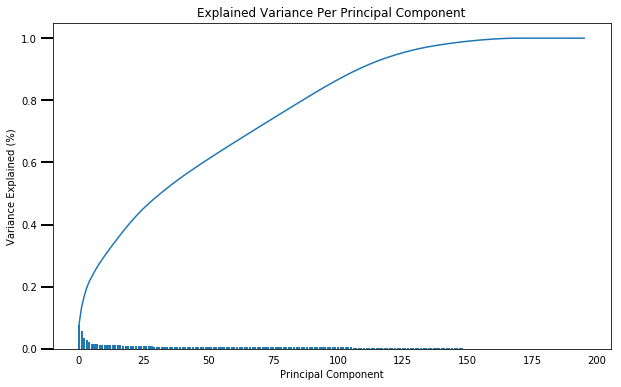

In [124]:
# Investigate the variance accounted for by each principal component.
pca_ratio = pca.explained_variance_ratio_

num_components=len(pca_ratio)
ind = np.arange(num_components)
vals = pca_ratio

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [125]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca2 = PCA(100)
azdias_pca2 = pca2.fit_transform(azdias_final)
azdias_pca2.shape

(781280, 100)

In [126]:
print("Total variance captured by the eigenvectors is: {var:.3f}".format(var=pca2.explained_variance_ratio_.sum()))

Total variance captured by the eigenvectors is: 0.860


### Discussion 2.2: Perform Dimensionality Reduction

I initially performed a PCA on the whole dataset in order to capture the variability of all eigenvectors. I, then, concluded that most of the information is retained within the first 100 components, by utilizing a scree plot. For that reason, I kept the first 100 vectors, which number would definitely be sufficient in terms of variability, but also reduces the dataset complexity significantly by 49%. In conclusion, I managed to retain 86% of the initial dataset information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [127]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def principals(df, pca, comp_num):
    weights = pd.DataFrame(pca.components_, columns=df.columns).iloc[comp_num]
    w_sort = weights.sort_values(ascending=False)
    return(w_sort)

firstvar = sorted(pca2.explained_variance_ratio_, reverse=True)[0] # Component variability
eigenmap = principals(azdias_final, pca2, 0)

print('{eigen1}\n{eigen2}\nVariability contribution: {var}'.format(eigen1=eigenmap.head(),eigen2=eigenmap.tail(), var=firstvar))

LP_STATUS_GROB_1.0    0.196737
PLZ8_ANTG3            0.188237
PLZ8_ANTG4            0.182900
HH_EINKOMMEN_SCORE    0.182476
ORTSGR_KLS9           0.162294
Name: 0, dtype: float64
KBA05_GBZ           -0.184111
PLZ8_ANTG1          -0.188050
FINANZ_MINIMALIST   -0.191421
KBA05_ANTG1         -0.192902
MOBI_REGIO          -0.206470
Name: 0, dtype: float64
Variability contribution: 0.07723612110703541


In [128]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

secondvar = sorted(pca2.explained_variance_ratio_, reverse=True)[1]
eigenmap2 = principals(azdias_final, pca2, 1)

print('{eigen1}\n{eigen2}\nVariability contribution: {var}'.format(eigen1=eigenmap2.head(),eigen2=eigenmap2.tail(), var=secondvar))

ALTERSKATEGORIE_GROB    0.233130
FINANZ_VORSORGER        0.218402
ZABEOTYP_3              0.198735
SEMIO_ERL               0.179774
SEMIO_LUST              0.163205
Name: 1, dtype: float64
SEMIO_TRADV                    -0.207775
FINANZ_UNAUFFAELLIGER          -0.214737
SEMIO_REL                      -0.214867
FINANZ_SPARER                  -0.227238
PRAEGENDE_JUGENDJAHRE_DECADE   -0.237617
Name: 1, dtype: float64
Variability contribution: 0.05681233672074968


In [129]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

thirdvar = sorted(pca2.explained_variance_ratio_, reverse=True)[2]
eigenmap3 = principals(azdias_final, pca2, 2)

print('{eigen1}\n{eigen2}\nVariability contribution: {var}'.format(eigen1=eigenmap3.head(),eigen2=eigenmap3.tail(), var=thirdvar))

SEMIO_VERT     0.317930
SEMIO_FAM      0.258556
SEMIO_SOZ      0.256330
SEMIO_KULT     0.248878
FINANZTYP_5    0.136895
Name: 2, dtype: float64
SEMIO_ERL    -0.207109
SEMIO_KRIT   -0.264671
SEMIO_DOM    -0.278649
SEMIO_KAEM   -0.312279
ANREDE_KZ    -0.342624
Name: 2, dtype: float64
Variability contribution: 0.03490915878932209


In [130]:
def plot_components(df, pca, num_component, num_features):

    # PCA components
    components = principals(df, pca, num_component)
    components = pd.concat([components.head(num_component), components.tail(num_component)])
    #components.index = dimensions

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(components)+1)]

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(components), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

### Discussion 2.3: Interpret Principal Components

During the investigation of the top three components, that contribute for 18.7% of the total dataset variability, we inferred the following attributes in terms of the general population behaviour. The major eigenvector is determined by the individuals' social status, his household income, but also the number of large buildings (>7 households) in PLZ8 region. On the contrary, it's inversely correlated with the individual's movement pattern, the number of individuals characterized financially as of "low financial interest" and the number of small buildings (<5 households) in PLZ* region. 

The second major eigenvector is mainly determined by the individual's age, the number of individuals characterized financially as "prepared" and their behavior as per the energy consumption via their activities. It opposes to the individual's youth movement, the individuals characterized as "money savers" and the religious individuals. 

Lastly, the third principal component is highly correlated with the dreamful, family-minded and socially-minded individuals. However, its tendency repels the combatibe and dominant-minded individuals, as well as the gender traits. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [131]:
azdias_pca2.dtype

dtype('float64')

In [ ]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average within-cluster distances.
clusters = np.linspace(7, 28, 8)
scores = []
azdiaspca_cast = azdias_pca2.astype(float, casting='safe') # KMeans accepts 'int' as input
for k in clusters:
    kmeans = KMeans(int(k))
    kmeans.fit(azdiaspca_cast)
    score = -kmeans.score(azdiaspca_cast)
    scores.append(score)


In [132]:
# loading instance of k-means model & its scores
pickle_in = open("kmeans.pickle","rb")
kmeans_opt, preds = pickle.load(pickle_in)

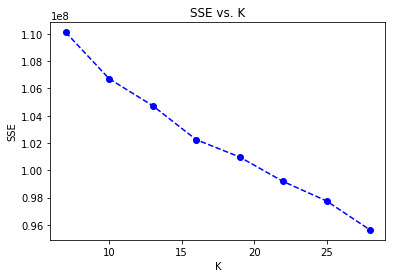

In [116]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [135]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
import time

start = time.time()

kmeans_opt = KMeans(45)
kmeans_opt.fit(azdias_pca2)
preds = kmeans_opt.predict(azdias_pca2)

end = time.time()
print(end - start)

919.7616221904755


In [136]:
score2 = -kmeans_opt.score(azdias_pca2)
print(score2)

86920077.6072


In [137]:
print(f'Cluster predictions are: {preds}')

Cluster predictions are: [ 2 27 17 ..., 41 13 35]


In [138]:
pickle_out = open("kmeans.pickle","wb")
pickle.dump((kmeans_opt, preds), pickle_out)
pickle_out.close()

### Discussion 3.1: Apply Clustering to General Population

Fitting the K-Means model has been a hectic process due to the dataset's size. For this reason, a decision had to be made as to what is the optimal number of clusters to be fitted, based on the apparent trade-off between the model's complexity and training time. Using the elbow method, for the first 30 clusters, there was a gradually decreasing trend of the fitting error. For that reason, the optimal number of clusters chosen to be utiized for the model was outside the scope of that graph and was chosen based on an estimation of training time per cluster of about 20''. The 43 clusters used aren't minimizing the error, but at least significantly reducing it and hence that's the number used based on which the population has been segmented. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [139]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

In [140]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data
customer_df = clean_data(customers, outliers, multi)
customer_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_WEALTH,CAMEO_STAGE,PLZ8_BAUMAX_SIZE,PLZ8_BAUMAX_TYPE
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,50.0,False,1.0,3.0,1.5,True
2,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,50.0,False,2.0,4.0,8.0,True
3,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,40.0,True,4.0,1.0,1.5,True
4,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,70.0,True,3.0,4.0,3.5,True
5,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,50.0,False,2.0,3.0,1.5,True


In [141]:
customer_col = list(customer_df.columns)
population_col = list(azdias_below15.columns)

s = set(population_col)
temp3 = [x for x in customer_col if x not in s]

In [142]:
# Number difference in features
len(temp3)

13

In [143]:
# Difference in features from original population dataset
diff = customer_df.columns.difference(azdias_below15.columns)
diff

Index(['CAMEO_DEUG_2015_X', 'CAMEO_DEU_2015_XX', 'LP_FAMILIE_FEIN_0.0',
       'LP_FAMILIE_GROB_0.0', 'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1',
       'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3', 'SHOPPER_TYP_-1',
       'SHOPPER_TYP_0', 'SHOPPER_TYP_1', 'SHOPPER_TYP_2', 'SHOPPER_TYP_3'],
      dtype='object')

In [144]:
# Different features included in customer set
diff.isin(customer_col)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [145]:
# Remove redundant features
customer_df2 = customer_df.drop(['SHOPPER_TYP_-1',
       'SHOPPER_TYP_0', 'SHOPPER_TYP_1', 'SHOPPER_TYP_2', 'SHOPPER_TYP_3'], axis=1)

In [146]:
# customer_df['PRAEGENDE_JUGENDJAHRE_MOVE'] = (customer_df['PRAEGENDE_JUGENDJAHRE_MOVE'] == True) 
# customer_df['PLZ8_BAUMAX_TYPE'] = (customer_df['PLZ8_BAUMAX_TYPE'] == True)

customer_full = imp.transform(customer_df2)
customer_full = pd.DataFrame(customer_full, columns=azdias_below15.columns)
customer_proc = scaler.transform(customer_full)
customer_final = pd.DataFrame(customer_proc, columns=azdias_below15.columns)
customer_pca = pca2.transform(customer_final)


In [147]:
#Cluster predictions for the customer demographics data
cust_preds = kmeans_opt.predict(customer_pca)

In [149]:
cust_preds

array([31, 42, 17, ..., 31, 14,  3], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

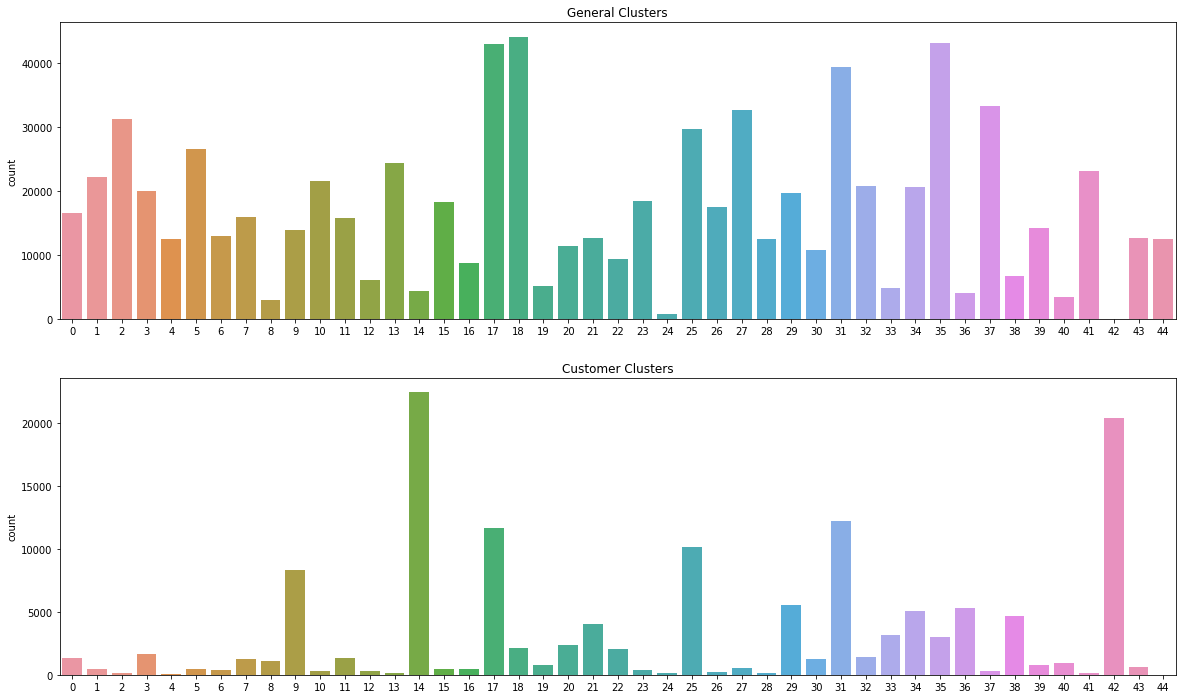

In [156]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(20,12))
    
ax1.set_title('General Clusters')
sns.countplot(preds, ax=ax1)

ax2.set_title('Customer Clusters')
sns.countplot(cust_preds, ax=ax2)

plt.show()


In [157]:
# Kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population
customer1 = scaler.inverse_transform(pca2.inverse_transform(kmeans_opt.cluster_centers_[14]))
customer2 = scaler.inverse_transform(pca2.inverse_transform(kmeans_opt.cluster_centers_[42]))


In [163]:
# Target Customer Type 1
cust_type1 = pd.Series(customer1, index=customer_df2.columns)
cust_type1.sort_values(ascending=False, inplace=True)
cust_type1

MIN_GEBAEUDEJAHR                1993.151465
KBA13_ANZAHL_PKW                 669.540894
PRAEGENDE_JUGENDJAHRE_DECADE      62.556440
ANZ_HAUSHALTE_AKTIV               11.215345
WOHNDAUER_2008                    10.031481
SEMIO_LUST                         5.045466
SEMIO_ERL                          4.976349
INNENSTADT                         4.899254
SEMIO_VERT                         4.887067
FINANZ_MINIMALIST                  4.522494
W_KEIT_KIND_HH                     4.442650
ORTSGR_KLS9                        4.376425
WOHNLAGE                           4.328864
REGIOTYP                           4.281719
SEMIO_KRIT                         4.226939
SEMIO_DOM                          4.215399
KBA05_GBZ                          4.207590
GEBAEUDETYP_RASTER                 4.188574
BALLRAUM                           4.131781
KONSUMNAEHE                        4.076331
SEMIO_SOZ                          4.063428
MOBI_REGIO                         4.023665
FINANZ_VORSORGER                

In [164]:
# Target customer type 2
cust_type2 = pd.Series(customer2, index=customer_df2.columns)
cust_type2.sort_values(ascending=False, inplace=True)
cust_type2

MIN_GEBAEUDEJAHR                1960.136229
KBA13_ANZAHL_PKW                 250.303121
PLZ8_BAUMAX_SIZE                  36.024624
PRAEGENDE_JUGENDJAHRE_DECADE      22.972033
BALLRAUM                          20.054591
GEBAEUDETYP_RASTER                19.301845
CAMEO_STAGE                       16.372590
SEMIO_MAT                         15.009889
KONSUMNAEHE                       14.354690
ONLINE_AFFINITAET                 14.212622
W_KEIT_KIND_HH                    13.250745
CAMEO_WEALTH                      12.667492
SEMIO_TRADV                       11.704738
MOBI_REGIO                        11.562601
FINANZ_HAUSBAUER                  10.923219
SEMIO_RAT                         10.202898
REGIOTYP                           9.533842
SEMIO_DOM                          8.902507
SEMIO_LUST                         8.786804
KBA05_ANTG2                        7.827107
KBA05_ANTG1                        7.650648
KBA05_ANTG4                        7.240456
PLZ8_ANTG2                      

In [168]:
# Kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population
general1 = scaler.inverse_transform(pca2.inverse_transform(kmeans_opt.cluster_centers_[37]))
general2 = scaler.inverse_transform(pca2.inverse_transform(kmeans_opt.cluster_centers_[2]))


In [169]:
gen_type1 = pd.Series(general1, index=customer_df2.columns)
gen_type1.sort_values(ascending=False, inplace=True)
gen_type1

MIN_GEBAEUDEJAHR                1992.366955
KBA13_ANZAHL_PKW                 573.753161
PRAEGENDE_JUGENDJAHRE_DECADE      87.574138
ANZ_HAUSHALTE_AKTIV               12.768716
WOHNDAUER_2008                     7.037029
SEMIO_KULT                         6.940702
SEMIO_FAM                          6.802904
SEMIO_SOZ                          6.582079
SEMIO_REL                          6.406907
ORTSGR_KLS9                        6.345487
SEMIO_VERT                         6.095334
SEMIO_PFLICHT                      5.700059
HH_EINKOMMEN_SCORE                 5.466448
SEMIO_MAT                          5.182819
SEMIO_TRADV                        4.934386
REGIOTYP                           4.731402
EWDICHTE                           4.661881
W_KEIT_KIND_HH                     4.539620
FINANZ_SPARER                      4.509519
SEMIO_RAT                          4.133039
FINANZ_UNAUFFAELLIGER              3.960822
INNENSTADT                         3.848711
PLZ8_BAUMAX_SIZE                

In [170]:
gen_type2 = pd.Series(general2, index=customer_df2.columns)
gen_type2.sort_values(ascending=False, inplace=True)
gen_type1

MIN_GEBAEUDEJAHR                1992.366955
KBA13_ANZAHL_PKW                 573.753161
PRAEGENDE_JUGENDJAHRE_DECADE      87.574138
ANZ_HAUSHALTE_AKTIV               12.768716
WOHNDAUER_2008                     7.037029
SEMIO_KULT                         6.940702
SEMIO_FAM                          6.802904
SEMIO_SOZ                          6.582079
SEMIO_REL                          6.406907
ORTSGR_KLS9                        6.345487
SEMIO_VERT                         6.095334
SEMIO_PFLICHT                      5.700059
HH_EINKOMMEN_SCORE                 5.466448
SEMIO_MAT                          5.182819
SEMIO_TRADV                        4.934386
REGIOTYP                           4.731402
EWDICHTE                           4.661881
W_KEIT_KIND_HH                     4.539620
FINANZ_SPARER                      4.509519
SEMIO_RAT                          4.133039
FINANZ_UNAUFFAELLIGER              3.960822
INNENSTADT                         3.848711
PLZ8_BAUMAX_SIZE                

### Discussion 3.3: Compare Customer Data to Demographics Data

Having analyzed both the general population, but also the customer segment of the data we end up with the following conclusions:

- The customers being **overrepresented** and thus can be within the target market of the mail-order company are staying in big houses- with over 11 households- have very low affinity towards being sensual and they're unlikely to have children


- On the other hand, the customer being **underrepresented**, are living in their house between 6-7 years, aren't known as cultural, family-minded or socially-minded and they are members of a community between 50k to 100k inhabitants

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.